In [36]:
! git clone https://github.com/jianxu305/nCov2019_analysis/
#! git pull

remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 8 (delta 6), reused 5 (delta 3), pack-reused 0
Unpacking objects: 100% (8/8), done.
From https://github.com/jianxu305/nCov2019_analysis
   04283c7..43b2310  master     -> origin/master
Updating 04283c7..43b2310
Fast-forward
 src/utils.py | 14 +++++++++++++-
 1 file changed, 13 insertions(+), 1 deletion(-)


In [ ]:
import sys
import os
os.chdir('/content/nCov2019_analysis/src')

sys.path.append('/content/nCov2019_analysis/src')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils   # some convenient functions
import matplotlib.font_manager as mfm
import datetime

%load_ext autoreload
%autoreload 2

In [2]:
dxy_raw = utils.load_chinese_data()

Last update:  2020-03-06 08:20:03.245000
Data date range:  2020-01-24 to 2020-03-06
Number of rows in raw data:  64634


In [3]:
dxy_frm = utils.aggDaily(dxy_raw)

In [4]:
jhs_raw = utils.load_jhs_raw()

In [5]:
jhs_frm = utils.jhs_daily(jhs_raw)

In [6]:
jhs_frm.tail()

,province/state,country/region,Last Update,cum_confirmed,cum_dead,cum_cured,Latitude,Longitude,update_time,update_date,new_confirmed,new_dead,new_cured
2170,"Los Angeles, CA",US,2020-03-04T18:13:18,7.0,0.0,0.0,34.0522,-118.2437,2020-03-04 18:13:18,2020-03-04,6.0,0.0,0.0
2171,"Orange County, CA",US,2020-03-04T02:13:11,3.0,0.0,0.0,33.7879,-117.8531,2020-03-04 02:13:11,2020-03-04,3.0,0.0,0.0
2172,"Placer County, CA",US,2020-03-04T19:53:02,2.0,1.0,0.0,39.0916,-120.8039,2020-03-04 19:53:02,2020-03-04,1.0,1.0,0.0
2173,"Snohomish County, WA",US,2020-03-04T19:53:02,8.0,1.0,0.0,48.0330,-121.8339,2020-03-04 19:53:02,2020-03-04,2.0,0.0,0.0
2174,"Westchester County, NY",US,2020-03-04T21:23:10,10.0,0.0,0.0,41.1220,-73.7949,2020-03-04 21:23:10,2020-03-04,9.0,0.0,0.0


## 1. Sanity Check
### 1.1 Take a Brief Look at the data

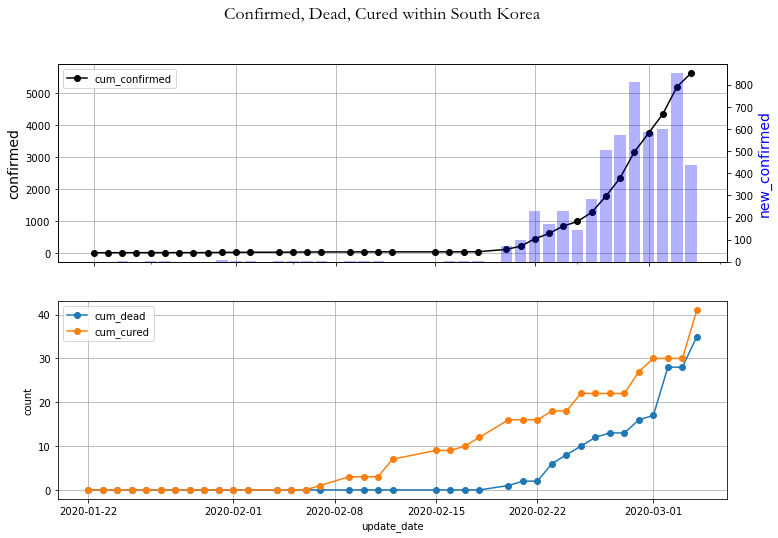

In [7]:
fig = utils.tsplot_conf_dead_cured(jhs_frm[jhs_frm['country/region'] == 'South Korea'], 
                                   title='Confirmed, Dead, Cured within South Korea', figsize=(12, 8))

### 1.2 Compare with Ding Xiang Yuan Chinese Data

In [ ]:
jhs_china = jhs_frm[jhs_frm['country/region'] == 'Mainland China'].groupby(['update_date'])[['cum_confirmed', 'cum_dead']].agg('sum')
jhs_china = jhs_china.add_suffix('_JHS').reset_index()

In [ ]:
dxy_china = dxy_frm.groupby(['update_date'])[['cum_confirmed', 'cum_dead']].agg('sum')
dxy_china = dxy_china.add_suffix('_DXY').reset_index()

In [ ]:
comp = pd.merge(jhs_china, dxy_china, on='update_date').set_index('update_date')

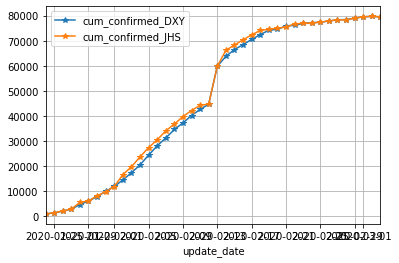

In [15]:
comp.plot(y=['cum_confirmed_DXY', 'cum_confirmed_JHS'], marker='*', grid=True)

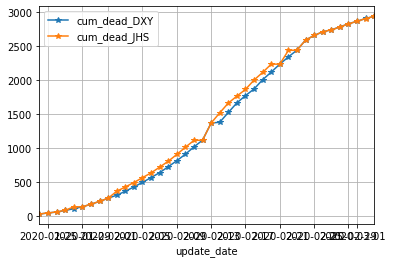

In [16]:
comp.plot(y=['cum_dead_DXY', 'cum_dead_JHS'], marker='*', grid=True)

## 2. Mortality Rate vs Confirmed Count

In [ ]:
import plotly.express as px
import chart_studio
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.io as pio

In [ ]:
api_key  = ''  # use you own key
user_name = ''  # use your own user name
chart_studio.tools.set_credentials_file(username=user_name, api_key=api_key)

In [6]:
# most international data only has country info, so do not drill down to finer level now
country_frm = jhs_frm.groupby(['country/region', 'update_date']).agg('sum')  

### Remove Some Data Problem
Japan and US has some dates with negative new_confirm

In [7]:
country_frm[country_frm['new_confirmed'] < 0]

cum_confirmed  cum_dead  cum_cured  Latitude  \
country/region update_date                                                 
Japan          2020-01-23             1.0       0.0        0.0       0.0   
               2020-02-07            25.0       0.0        1.0       0.0   

                            Longitude  new_confirmed  new_dead  new_cured  
country/region update_date                                                 
Japan          2020-01-23         0.0           -1.0       0.0        0.0  
               2020-02-07         0.0          -20.0       0.0        0.0

In [8]:
country_frm['new_confirmed'] = np.maximum(0, country_frm['new_confirmed'])   # Japan 1/23, 2/7, US 2/24 have new confirmed < 0, looks like data error

### Add Mortality Rate, Moving Average, etc

In [9]:
country_frm['mortality_rate'] = country_frm['cum_dead'] / country_frm['cum_confirmed']

In [11]:
country_frm = utils.add_moving_average(country_frm, ['country/region'], win_size=3)

In [13]:
# The next two columns are mainly for plot rendering
color_countries = ['Mainland China', 'Japan', 'South Korea', 'Iran', 'Italy', 'Germany', 
                   'US', 'France', 'Spain', 'Diamond Princess']
country_frm['color'] = np.where(country_frm.index.get_level_values('country/region').isin(color_countries), 
                                country_frm.index.get_level_values('country/region'), 
                                'Other')

In [14]:
country_ex_china = country_frm[country_frm.index.get_level_values('country/region') != 'Mainland China']

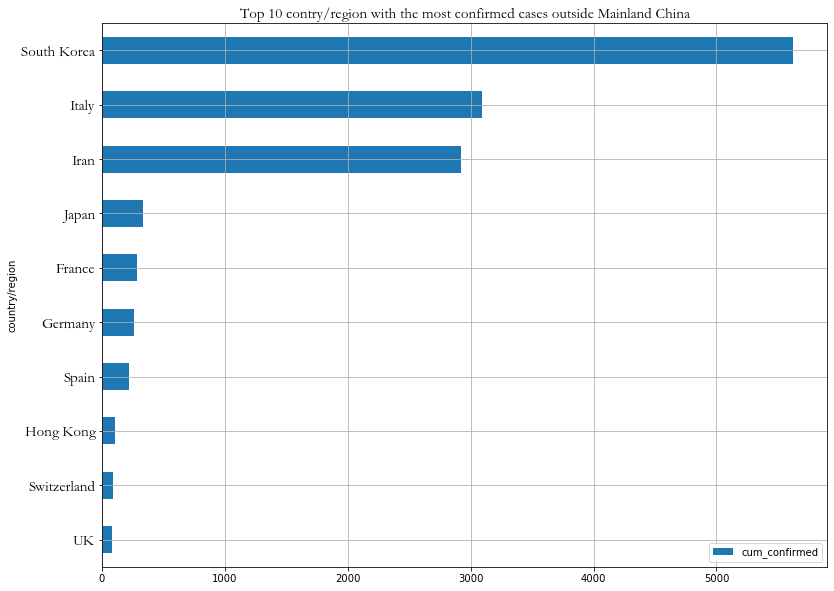

In [16]:
fig = utils.cross_sectional_bar(country_ex_china.reset_index(), '2020-03-04', 'cum_confirmed', 'country/region', 10,
                                title='Top 10 contry/region with the most confirmed cases outside Mainland China')

In [47]:
date = datetime.date(2020, 3, 2)
fig = px.scatter(country_ex_china.loc[(slice(None), date), :].reset_index(),
                 x='cum_confirmed', 
                 y='mortality_rate',  
                 size='new_confirmed_logMA', 
                 color='color',
                 #color_continuous_scale=px.colors.sequential.Jet,
                 hover_data=['country/region', 'cum_dead', 'cum_confirmed', 'new_confirmed', 'new_dead'],
                 title='Mortality Rate vs Confirmed by Country/Region as of ' + str(date))
fig.update_layout(xaxis_type="log", xaxis_title='Confirmed Count', yaxis_title='Mortality Rate')
fig.layout.yaxis.tickformat = ',.1%'  # set display to % format
fig.show()

In [ ]:
pio.write_html(fig, file='index.html', auto_open=True)